In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from scipy.optimize import minimize

import random


## Data Cleaning  

In [4]:
# Arrange Data 
data = pd.read_csv("data/raw/CleanData_20180222.csv", encoding="shift-jis")
data_hh = pd.read_csv("data/raw/HHsize.csv")
data_cpi = pd.read_csv("data/raw/zni2015s.csv", encoding="shift-jis")

df = data[['Maker','Type','Name','Year','Sales','Model','price','kata','weight','FuelEfficiency','HorsePower','overall_length','overall_width','overall_height']]
df = df.rename(columns={'Year': 'year'})

# merge Car Data with HH
df = pd.merge(df, data_hh, on='year')

df["HH"]=df["HH"].str.replace(",","")

data_cpi.drop(index=data_cpi.index[0:5], inplace=True)
data_cpi.rename(columns={'類・品目': 'year', '総合': 'cpi'}, inplace=True)
data_cpi['year'] = data_cpi['year'].astype('int')
data_cpi['cpi'] = data_cpi['cpi'].astype('float')

# merge df with CPI
df = pd.merge(df, data_cpi, on='year')

# drop the null data in FuelEfficiency
df = df.dropna(subset=['FuelEfficiency'])

# realization of price (2016 base)
cpi2016 = data_cpi[data_cpi['year']==2016]
cpi2016 = float(cpi2016.values[0][1])
df['price'] = (df['price'] / (df['cpi'] / cpi2016)) / 100

# Create additional columns
df['size'] = (df['overall_height'] / 1000) * (df['overall_length'] / 1000) * (df['overall_width'] / 1000)
df['hppw'] = df['HorsePower'] / df['weight']

# Create Car ID (based on Model)
df['car_id'] = le.fit_transform(df['Name'])


# Define outside option and market share
df['inside_total'] = df[['year','Sales']].groupby('year').transform('sum')
df['HH'] = df['HH'].astype('int')
df['outside_total'] = df['HH'] - df['inside_total']
df['share'] = df['Sales'] / df['HH']
df['share0'] = df['outside_total'] / df['HH']

## Instrumental Variables  

In [5]:
attribute_cols = ['hppw', 'FuelEfficiency', 'size']

for i in attribute_cols:
    df[f"sum_own_{i}"] = df[['year', 'Maker', i]].groupby(['year','Maker']).transform('sum')[i]
    df[f"sqr_{i}"] = df[i] ** 2
    col_name = "sqr_" + i
    df[f"sqr_sum_own_{i}"] = df[['year', 'Maker', col_name]].groupby(['year','Maker']).transform('sum')[col_name]
for i in attribute_cols:
    df[f"sum_market_{i}"] = df[['year', i]].groupby(['year']).transform('sum')[i]
    col_name = "sqr_" + i
    df[f"sqr_sum_market_{i}"] = df[['year', col_name]].groupby(['year']).transform('sum')[col_name]
    
maker_n = df[['year', 'Maker']].groupby(['year','Maker']).transform('size')
market_n = df[['year']].groupby(['year']).transform('size')

In [6]:
# BLP IV
for i in attribute_cols:
    df[f"iv_BLP_own_{i}"] = df[f"sum_own_{i}"] - df[i]
    df[f"iv_BLP_other_{i}"] = df[f"sum_market_{i}"] - df[i]

# Differentiation IV
for i in attribute_cols:
    df[f"iv_GH_own_{i}"] = (maker_n - 1) * df[f"sqr_{i}"] + (df[f"sqr_sum_own_{i}"] - df[f"sqr_{i}"]) - 2 * df[i] * (df[f"sum_own_{i}"] - df[i])
    df[f"iv_GH_other_{i}"] = (market_n - maker_n) * df[f"sqr_{i}"] + (df[f"sqr_sum_market_{i}"] - df[f"sqr_sum_own_{i}"]) - 2 * df[i] * (df[f"sum_market_{i}"] - df[f"sum_own_{i}"])

## Logit Model

In [7]:
id_list = np.sort(df['car_id'].unique()).tolist()
J = len(id_list)

In [8]:
random_state = 42
random.seed(random_state)
nippyo_id = np.sort(random.sample(id_list, 30))

df_nippyo = df[['year','share','car_id', 'Sales', 'price', 'hppw','FuelEfficiency','size']][df['car_id'].isin(nippyo_id)]
df_nippyo['log_sales'] = np.log(df['Sales'])
df_nippyo['log_price'] = np.log(df['price'])

In [9]:
df['logit_share'] = np.log(df['share']) - np.log(df['share0'])
#fromula logit_share ~ price + hppw + FuelEfficiency + size
X = df[['price','hppw','FuelEfficiency','size']]
y = df['logit_share']
ols = sm.OLS(y, sm.add_constant(X)).fit()

# 2SLS with Differentiation IV
dif = IV2SLS.from_formula("logit_share ~ 1 + hppw + FuelEfficiency + size + \
                [price ~ iv_GH_own_hppw + iv_GH_own_FuelEfficiency + iv_GH_own_size + iv_GH_other_hppw + iv_GH_other_FuelEfficiency + iv_GH_other_size]", df).fit()

display(ols.summary())
display(dif.summary)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logit_share   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     129.7
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           1.67e-97
Time:                        12:27:41   Log-Likelihood:                -3401.3
No. Observations:                1823   AIC:                             6813.
Df Residuals:                    1818   BIC:                             6840.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -12.2548      0.375    -32.718      0.000     -12.989     -11.520
price             -0.2551      0.030     -8.456      0.000      -0.314      -0.196
hppw              -0.6542      1.532     -0.427      0.669      -3.659       2.351
FuelEfficiency     0.1301      0.009     13.927      0.000       0.112       0.148
size               0.1822      0.020      9.235      0.000       0.144       0.221
==============================================================================
Omnibus:                      322.488   Durbin-Watson:                   0.724
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              609.516
Skew:                          -1.073   Prob(JB):                    4.42e-133
Kurtosis:                       4.848   Cond. No.                         858.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:            logit_share   R-squared:                      0.1805
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1787
No. Observations:                1823   F-statistic:                    459.59
Date:                Tue, Oct 07 2025   P-value (F-stat)                0.0000
Time:                        12:27:41   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
==================================================================================
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept         -12.973     0.3921    -33.084     0.0000     -13.741     -12.204
hppw               8.4256     2.6339     3.1989     0.0014      3.2632      13.588
FuelEfficiency     0.1268     0.0096     13.159     0.0000      0.1079      0.1457
size               0.2363     0.0222     10.660     0.0000      0.1929      0.2798
price             -0.5521     0.0804    -6.8708     0.0000     -0.7096     -0.3946
==================================================================================

Endogenous: price
Instruments: iv_GH_own_hppw, iv_GH_own_FuelEfficiency, iv_GH_own_size, iv_GH_other_hppw, iv_GH_other_FuelEfficiency, iv_GH_other_size
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [10]:
# Elasticity Matrix
# car_idが121からずれるのは謎
ex_id = [86,116,150,172]

# Filter dataset for 2016
dt2016 = df[df["year"] == 2016][["price", "share", "car_id"]].sort_values("car_id")
price = dt2016["price"].values
share = dt2016["share"].values
car_id = dt2016['car_id'].values

# Compute elasticities
own_elas = dif.params["price"] * price * (1 - share)
cross_elas = (-1) * dif.params["price"] * price * share

J = len(own_elas)
elas_mat = np.tile(cross_elas, (J, 1))
np.fill_diagonal(elas_mat, own_elas)

mask = np.isin(car_id, ex_id)
result = elas_mat[np.ix_(mask, mask)]
print(result)

[[-1.76455369e+00  1.22041722e-03  1.48175337e-04  1.84509423e-03]
 [ 1.14928839e-03 -8.18688564e-01  1.48175337e-04  1.84509423e-03]
 [ 1.14928839e-03  1.22041722e-03 -9.59449003e-01  1.84509423e-03]
 [ 1.14928839e-03  1.22041722e-03  1.48175337e-04 -6.71750163e-01]]


## Nested Logit

In [11]:
# Create the Nests by car Type (df['Type'])

# summation of attributions within Maker
for i in attribute_cols:
    df[f"sum_own_{i}_nest"] = df[['year', 'Maker','Type', i]].groupby(['year','Maker','Type']).transform('sum')[i]
    df[f"sqr_{i}"] = df[i] ** 2
    col_name = "sqr_" + i
    df[f"sqr_sum_own_{i}_nest"] = df[['year', 'Maker', 'Type', col_name]].groupby(['year','Maker','Type']).transform('sum')[col_name]
# summation of attributions within Market
for i in attribute_cols:
    df[f"sum_market_{i}_nest"] = df[['year','Type', i]].groupby(['year','Type']).transform('sum')[i]
    col_name = "sqr_" + i
    df[f"sqr_sum_market_{i}_nest"] = df[['year', 'Type', col_name]].groupby(['year','Type']).transform('sum')[col_name]

nested_market_n = df.groupby(['year', 'Type'])['Sales'].transform('size')
group_n = df[['year','Maker','Type']].groupby(['year','Maker','Type']).transform('size')

# BLP IV
for i in attribute_cols:
    df[f"iv_BLP_own_{i}_nest"] = df[f"sum_own_{i}_nest"] - df[i]
    df[f"iv_BLP_other_{i}_nest"] = df[f"sum_market_{i}_nest"] - df[i]

df['iv_BLP_own_num_nest'] = group_n - 1
df['iv_BLP_other_num_nest'] = nested_market_n - group_n

# Differentiation IV
for i in attribute_cols:
    df[f"iv_GH_own_{i}_nest"] = (group_n - 1) * df[f"sqr_{i}"] \
                                + (df[f"sqr_sum_own_{i}_nest"] - df[f"sqr_{i}"]) \
                                - 2 * df[i] * (df[f"sum_own_{i}_nest"] - df[i])
    df[f"iv_GH_other_{i}_nest"] = (nested_market_n - group_n) * df[f"sqr_{i}"] \
                                + (df[f"sqr_sum_market_{i}_nest"] - df[f"sqr_sum_own_{i}_nest"]) \
                                - 2 * df[i] * (df[f"sum_market_{i}_nest"] - df[f"sum_own_{i}_nest"])

In [12]:
df['logit_share'] = np.log(df['share']) - np.log(df['share0'])
# Inside share

df['inside_share'] = df['Sales'] / df.groupby(['year', 'Type']).transform('sum')['Sales']
df['log_inside_share'] = np.log(df['inside_share'])

In [13]:
nested_ols = smf.ols("logit_share ~ 1 + price + log_inside_share + hppw + FuelEfficiency + size", data=df).fit(cov_type='HC3')

nested_blp = IV2SLS.from_formula("logit_share ~ 1 + hppw + FuelEfficiency + size + \
                    [price + log_inside_share ~ iv_BLP_own_hppw_nest + iv_BLP_own_FuelEfficiency_nest + iv_BLP_own_size_nest \
                                                + iv_BLP_other_hppw_nest + iv_BLP_other_FuelEfficiency_nest + iv_BLP_other_size_nest \
                                                + iv_BLP_own_num_nest + iv_BLP_other_num_nest]", data=df).fit()

display(nested_ols.summary())
display(nested_blp.summary)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logit_share   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     1673.
Date:                Tue, 07 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:27:41   Log-Likelihood:                -1824.9
No. Observations:                1823   AIC:                             3662.
Df Residuals:                    1817   BIC:                             3695.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -7.5571      0.186    -40.633      0.000      -7.922      -7.193
price               -0.3073      0.024    -12.590      0.000      -0.355      -0.259
log_inside_share     0.7820      0.012     66.996      0.000       0.759       0.805
hppw                10.6364      0.864     12.306      0.000       8.942      12.330
FuelEfficiency       0.0551      0.004     13.810      0.000       0.047       0.063
size                 0.1557      0.007     21.132      0.000       0.141       0.170
==============================================================================
Omnibus:                      249.985   Durbin-Watson:                   0.318
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              391.163
Skew:                          -0.944   Prob(JB):                     1.15e-85
Kurtosis:                       4.259   Cond. No.                         898.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:            logit_share   R-squared:                      0.7647
Estimator:                    IV-2SLS   Adj. R-squared:                 0.7641
No. Observations:                1823   F-statistic:                    1399.6
Date:                Tue, Oct 07 2025   P-value (F-stat)                0.0000
Time:                        12:27:41   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
====================================================================================
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
Intercept           -9.5480     0.2385    -40.039     0.0000     -10.015     -9.0807
hppw                 18.925     1.9617     9.6473     0.0000      15.080      22.770
FuelEfficiency       0.0691     0.0063     11.037     0.0000      0.0568      0.0813
size                 0.2275     0.0122     18.643     0.0000      0.2036      0.2514
price               -0.6542     0.0528    -12.395     0.0000     -0.7576     -0.5507
log_inside_share     0.5951     0.0353     16.881     0.0000      0.5260      0.6642
====================================================================================

Endogenous: price, log_inside_share
Instruments: iv_BLP_own_hppw_nest, iv_BLP_own_FuelEfficiency_nest, iv_BLP_own_size_nest, iv_BLP_other_hppw_nest, iv_BLP_other_FuelEfficiency_nest, iv_BLP_other_size_nest, iv_BLP_own_num_nest, iv_BLP_other_num_nest
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [14]:
alpha1 = nested_ols.params['price']
sigma1 = nested_ols.params['log_inside_share']
alpha2 = nested_blp.params['price']
sigma2 = nested_blp.params['log_inside_share']

#self_elasticity
df['own_elas_ols'] = alpha1 * df['price'] * (1 - (sigma1 * df['inside_share']) - (1-sigma1)*df['share'])/(1 - sigma1)
df['own_elas_blp'] = alpha2 * df['price'] * (1 - (sigma2 * df['inside_share']) - (1-sigma2)*df['share'])/(1 - sigma2)

display(df[['own_elas_ols', 'own_elas_blp']].describe())

,own_elas_ols,own_elas_blp
count,1823.000000,1823.000000
mean,-3.521312,-4.049353
std,2.558495,2.937747
min,-17.793584,-20.401493
25%,-4.017510,-4.613132
50%,-2.843831,-3.266397
75%,-1.980574,-2.273343
max,-0.962570,-1.112620


In [15]:
dt2016 = df[df["year"] == 2016][["price", "share", "car_id", "inside_share", "Type"]].sort_values("car_id")
price = dt2016["price"].values
share = dt2016["share"].values
car_id = dt2016['car_id'].values
inside_share = dt2016['inside_share'].values
group = dt2016['Type'].values

own_elas = alpha2 * price * (1- sigma2 * inside_share - (1-sigma2)*share) / (1-sigma2)

cross_elas_other_group = (-1) * alpha2 * price * share
J = len(own_elas)
elas_mat = np.tile(cross_elas_other_group, (J, 1))
np.fill_diagonal(elas_mat, own_elas)

# Cross elasticity within the group
price_l_mat = np.tile(price, (J, 1))
share_l_mat = np.tile(share, (J, 1))
insideshare_l_mat = np.tile(inside_share, (J, 1))
cross_elas_samegroup = (-1) * alpha2 * price_l_mat * (sigma2 * insideshare_l_mat + (1 - sigma2) * share_l_mat) / (1 - sigma2)

# Indicator matrices for same group and different group
temp_mat1 = np.tile(group, (J, 1))
temp_mat2 = temp_mat1.T
ind_same_group = (temp_mat1 == temp_mat2)
ind_other_group = (temp_mat1 != temp_mat2)

# Construct Elasticity Matrix
elas_mat_nl = cross_elas_samegroup * ind_same_group + cross_elas_other_group * ind_other_group
np.fill_diagonal(elas_mat_nl, own_elas)

# Select specific NameID values
selected_ids = [86,116,150,172]
mask = np.isin(car_id, selected_ids)
result_nl = elas_mat_nl[np.ix_(mask, mask)]

print(result_nl)


[[-5.11969591e+00  5.07129664e-02  6.15724750e-03  2.18614068e-03]
 [ 4.77572936e-02 -2.34880799e+00  6.15724750e-03  2.18614068e-03]
 [ 4.77572936e-02  5.07129664e-02 -2.80217098e+00  2.18614068e-03]
 [ 1.36172237e-03  1.44599863e-03  1.75564004e-04 -1.83296347e+00]]


## Random Coefficient Model

$$u_{ijt} = \beta^0_i + \beta^{size}_i \text{size}_{jt} + \beta^{fuelefficiency}\text{fuelefficiency}_{jt} 
            + \beta^{hppw}\text{hppw}_{jt} - \alpha_i p_{jt} + \xi_{jt} + \epsilon_{ijt}$$

#### 方針
定数項とサイズと価格のパラメータに異質性を仮定  

線形な部分（$\delta_{jt}(\theta_1) = -\alpha p_{jt} + \beta' x_{jt} + \xi_{jt}$）と非線形な部分（$\mu_{ijt}(\theta_2) = \left[ \Pi D_i + \Sigma v_i \right]' \begin{bmatrix}     p_{jt} \\     x_{jt} \end{bmatrix}$）  

1. Market Shareの導出： 個人の購入確率　$s_{ijt}(D_i,\nu_i) = \frac{\text{exp}(\delta_{jt}(\theta_1) + \mu_{ijt}(\theta_2))}{1+\sum_{j=1}^{J_t}\text{exp}(\delta_{jt}(\theta_1) + \mu_{ijt}(\theta_2))}$　を積分すれば市場シェアが出てくるが、解析的に解けない → random samplingで数値計算  

2. BLPアルゴリズムで平均効用を算出： 初期値df['logit_share']（i.e. logit modelのシェア $log(s_{jt}/s_{0t}) = \delta_{jt}$）でマーケットシェアを求めて、df['share']との差を求める。この差とdf['logit_share']を足したものを新しい値として更新していく。

3. GMM目的関数は $G(\theta) = \xi(\theta)' ZWZ' \xi(\theta)$ で、これを最小にするように $\xi$ を求める

### Step1 下準備

In [16]:
df.sort_values(['year','car_id'],inplace=True)
info = df[['year','car_id']]

n = len(info['year'])
t = len(info['year'].unique())

# mean utility
df['cons'] = 1
X1 = df.copy()
X1 = X1[['cons','price','FuelEfficiency','hppw','size']]

# nonlinear coef
X2 = df.copy()
X2 = X2[['cons','price','size']]

# IV matrix
Z = df.copy()
Z = Z[[col for col in Z.columns if (col in ['cons','FuelEfficiency','hppw','size']) or (col.startswith('iv_GH') and not col.endswith('nest'))]]

# market share
share_vec = df.copy()
share_vec = share_vec['share'].to_numpy()

# Bundle matrices into a dictionary
datalist = {
    'X1': X1,
    'X2': X2,
    'Z': Z,
    'ShareVec': share_vec,
    'marketindex': df['year'].values,
    'logitshare': df['logit_share'].values
}

set seed

In [17]:
random_state = 111
np.random.seed(random_state)

nsim = 500

draw_vec = np.random.randn(nsim * X2.shape[1])
datalist['draw_vec'] = draw_vec

# Parameters dictionary
parameter = {
    'Nsim': nsim,
    'T': t,
    'N': n,
    'theta2': [0.001, 0.001, 0.001] # const, price, size
}

# Construct tempmat for market indexing
marketindex = datalist['marketindex']
uniquemarketindex = np.sort(np.unique(marketindex))
temp1 = np.tile(uniquemarketindex, (n, 1))
temp2 = np.tile(marketindex, (t, 1)).T
tempmat = (temp1 == temp2).astype(int)
datalist['tempmat'] = tempmat

### Step2 Calculate market share

In [18]:
def f_mktshare(datalist, parameter, delta):
    
    X2 = datalist['X2'].to_numpy()
    ns = parameter['Nsim']
    t = parameter['T']
    n = parameter['N']
    draw_vec = datalist['draw_vec']
    theta2 = parameter['theta2']
    k2 = len(theta2)
    draw_vec = datalist['draw_vec'][:ns * k2]
    market_index = datalist['marketindex']
    
    denom_outside = np.exp(np.zeros((t,ns)))
    
    mu = X2 @ np.diag(theta2) @ draw_vec.reshape(k2, ns)
    
    delta_mu = delta  @ np.ones((1, ns)) + mu
    exp_delta_mu = np.exp(delta_mu)
    
    tempmat = datalist['tempmat']
    denom_temp = (tempmat.T @ exp_delta_mu)
    denom_temp += denom_outside
    denom = tempmat @ denom_temp
    
    s_jt_i = np.array(exp_delta_mu) / np.array(denom)
    s_jt = s_jt_i.mean(axis=1)
    
    return s_jt

### Step 3 Berry Inversion

In [19]:
# 元のコードだと平均効用を指数に変換して評価してるから、1e-11にすぐ行く？
'''
def f_contraction1(datalist, parameter, delta_ini):
    
    tol = 1e-11
    norm = 1e+10
    share_obs = datalist['ShareVec'].reshape(-1, 1)

    delta_old = delta_ini.copy()
    exp_delta_old = np.exp(delta_old)

    iter = 0

    while norm > tol and iter < 1000:
        pred_mkt_share = f_mktshare(datalist, parameter, delta_old)
        exp_delta = exp_delta_old * share_obs / pred_mkt_share.reshape(-1, 1)
        nor = np.abs(exp_delta - exp_delta_old)
        norm = np.max(nor)

        exp_delta_old = exp_delta
        delta_old = np.log(exp_delta_old)
        iter += 1

    return delta_old
'''

"\ndef f_contraction1(datalist, parameter, delta_ini):\n    \n    tol = 1e-11\n    norm = 1e+10\n    share_obs = datalist['ShareVec'].reshape(-1, 1)\n\n    delta_old = delta_ini.copy()\n    exp_delta_old = np.exp(delta_old)\n\n    iter = 0\n\n    while norm > tol and iter < 1000:\n        pred_mkt_share = f_mktshare(datalist, parameter, delta_old)\n        exp_delta = exp_delta_old * share_obs / pred_mkt_share.reshape(-1, 1)\n        nor = np.abs(exp_delta - exp_delta_old)\n        norm = np.max(nor)\n\n        exp_delta_old = exp_delta\n        delta_old = np.log(exp_delta_old)\n        iter += 1\n\n    return delta_old\n"

In [20]:
def f_contraction(datalist, parameter, delta_ini):
    
    tol = 1e-11
    norm = 1e+10
    share_obs = datalist['ShareVec'].reshape(-1, 1)

    delta_old = delta_ini.copy()
    

    iter = 0

    while norm > tol and iter < 1000:
        pred_mkt_share = f_mktshare(datalist, parameter, delta_old)
        updated_delta = delta_old + np.log(share_obs) - np.log(pred_mkt_share.reshape(-1, 1))
        nor = np.abs(updated_delta - delta_old)
        norm = np.max(nor)

        delta_old = updated_delta
        iter += 1

    return delta_old

### Step4 Optimize GMM

In [21]:
def f_GMMobj(theta2, parameter, datalist, option):
    global delta_global
    param = parameter.copy()
    param['theta2'] = theta2

    delta_ini = delta_global.copy()
    delta = f_contraction(datalist, param, delta_ini)
    delta_global = delta

    X1 = datalist['X1'].to_numpy()
    Z = datalist['Z'].to_numpy()

    if datalist['weight_mat_option'] == "2SLS":
        W = np.linalg.inv(Z.T @ Z) # weighted matrix = inverse of (inner product of transposed Z and Z)
    elif datalist['weight_mat_option'] == "Ident":
        W = np.eye(Z.shape[1]) # weighted matrix = identity matrix
    else:
        raise ValueError("SET 'datalist['weight_mat_option']' !")

    beta_hat = np.linalg.inv(X1.T @ Z @ W @ Z.T @ X1) @ (X1.T @ Z @ W @ Z.T @ delta)
    Xi = delta - X1 @ beta_hat
    obj = Xi.T @ Z @ W @ Z.T @ Xi

    if option == 0:
        return obj
    elif option == 1:
        return {'output': obj, 'beta_hat': beta_hat, 'delta': delta}
    else:
        raise ValueError("SET the argument 'option' to 0 or 1 !!")


最適化実行

In [22]:
# 3分ぐらいかかる
datalist['weight_mat_option'] = "2SLS"

delta_global = df['logit_share'].values.reshape(-1, 1)

# initial param（heterogeneity of [cons, price, size]）
initial_theta2 = np.array([18, 0.3, 0.01])
bounds = [(0, None), (0, None), (0, None)]  # 非負制約

# 最適化
result = minimize(
    fun=lambda theta2: f_GMMobj(theta2, parameter, datalist, option=0),
    x0=initial_theta2,
    method='L-BFGS-B',
    bounds=bounds
)

result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 173.85970833374145
        x: [ 8.612e+00  4.458e-01  0.000e+00]
      nit: 13
      jac: [-2.638e-02 -3.678e-02  1.130e+01]
     nfev: 140
     njev: 35
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

### Step 5 標準誤差の計算

In [23]:
def f_SE(theta2, parameter, datalist):
    param = parameter
    param['theta2'] = theta2
    
    delta_ini = datalist['logitshare'].reshape(-1, 1)
    
    # contraction mapping
    delta = f_contraction(datalist, param, delta_ini)
    
    # object func
    X1 = datalist['X1'].to_numpy()
    Z = datalist['Z'].to_numpy()
    
    if datalist['weight_mat_option'] == "2SLS":
        W = np.linalg.inv(Z.T @ Z)
    elif datalist['weight_mat_option'] == "Ident":
        W = np.eye(Z.shape[1])
    else:
        raise ValueError("SET 'datalist['weight_mat_option']' !!")

    beta_hat = np.linalg.inv(X1.T @ Z @ W @ Z.T @ X1) @ (X1.T @ Z @ W @ Z.T @ delta)
    Xi = delta - (X1 @ beta_hat)

    Omega_hat = np.zeros((Z.shape[1], Z.shape[1]))
    for ii in range(param['N']):
        Zi = Z[ii, :].reshape(-1, 1)
        Omega_hat = Omega_hat + ((Zi @ Zi.T) * (Xi[ii] ** 2)) / param['N']

    Ddelta = np.zeros((param['N'], len(theta2)))
    for k in range(len(theta2)):
        tempparam = param.copy()
        tempparam['theta2'][k] += 1e-6
        delta_add = f_contraction(datalist, tempparam, delta_ini)
        Ddelta[:, k] = ((delta_add - delta) / 1e-6).ravel()

    G = (1 / param['N']) * Z.T @ np.hstack([-X1, Ddelta])

    temp = np.linalg.inv(G.T @ W @ G)
    AsyVarMat = temp @ (G.T @ W @ Omega_hat @ W @ G) @ temp
    Ase = np.sqrt(np.diag(AsyVarMat) / param['N'])

    return Ase

In [24]:
# Run GMM objective function and compute standard errors
result2 = f_GMMobj(result['x'], parameter, datalist, option=1)

delta = result2['delta']

se = f_SE(theta2=result['x'], parameter=parameter, datalist=datalist)

beta_hat = np.vstack([result2['beta_hat'], result['x'][0], result['x'][1], result['x'][2]])
beta_labels = ['const', 'price', 'FuelEfficiency', 'hppw', 'size', 'random_constant', 'random_price', 'random_size']

result_table = pd.DataFrame(beta_hat, columns=['coeff'], index=beta_labels)
result_table['se'] = se

print(result_table)

                     coeff        se
const           -22.738619  8.097438
price            -1.079780  0.288854
FuelEfficiency    0.112174  0.012564
hppw              9.246494  3.138124
size              0.285504  0.078015
random_constant   8.612348  6.010721
random_price      0.445818  0.908038
random_size       0.000001  0.963262


### 価格弾力性

In [25]:
# beta hatをデータフレーム化
beta_hat = pd.DataFrame(beta_hat, columns=['coeff'], index=beta_labels)

In [26]:
def f_elasticity(datalist, parameter, beta_hat, delta):
    
    X2 = datalist['X2'].to_numpy()
    ns = parameter['Nsim']
    n = parameter['N']
    theta2 = parameter['theta2']
    k2 = len(theta2)
    draw_vec = datalist['draw_vec'][:ns * k2]
    price = datalist['X1']['price'].values.reshape(-1, 1)
    uniquemarketindex = np.sort(np.unique(datalist['marketindex'])) # datalistにuniquemarketindexはおそらくない
    marketindex = datalist['marketindex']
    t = len(uniquemarketindex)

    denom_outside = np.exp(np.zeros((t,ns)))
    mu = X2 @ np.diag(theta2) @ draw_vec.reshape(k2, ns)
    delta_mu = delta  @ np.ones((1, ns)) + mu
    exp_delta_mu = np.exp(delta_mu)
    tempmat = datalist['tempmat']
    denom_temp = (tempmat.T @ exp_delta_mu)
    denom_temp += denom_outside
    denom = tempmat @ denom_temp
    s_jt_i = np.array(exp_delta_mu) / np.array(denom)

    draw_for_price = draw_vec.reshape(k2, ns)[1, :] # priceは[1] [0]だとconstのランダム抽出
    alpha_i = beta_hat.loc['price'].values  + beta_hat.loc['random_price'].values * draw_for_price

    elaslist = []

    # Create elas matrix for each market
    for tau in range(t):
        J_t = np.sum(marketindex == (2005 + tau + 1))
        ag_model_s_i = s_jt_i[marketindex == (2005 + tau + 1), :]
        ag_model_s = np.mean(ag_model_s_i, axis=1).reshape(-1, 1)
        elasmat = np.zeros((J_t, J_t))
        price_t = price[marketindex == (2005 + tau + 1)].flatten()

        # Compute elas
        for k in range(J_t):
            for j in range(J_t):
                if k != j: # cross elas
                    elasmat[k, j] = -price_t[k] * (1 / ag_model_s[j, 0]) * np.mean(alpha_i * ag_model_s_i[j, :] * ag_model_s_i[k, :])
                else: # own elas
                    elasmat[k, j] = price_t[j] * (1 / ag_model_s[j, 0]) * np.mean(alpha_i * ag_model_s_i[j, :] * (1 - ag_model_s_i[j, :]))
        
        elaslist.append({
            f"elasmat_{2005 + tau + 1}": elasmat
        })

    return elaslist


In [27]:
# パラメータ設定
parameter["theta2"] = result["x"]

# 弾力性行列の計算
elasticity = f_elasticity(datalist=datalist, parameter=parameter, beta_hat=beta_hat, delta=delta)

# 2016年のNameIDの抽出
NameID2016 = df[df["year"] == 2016]["car_id"].tolist()

# 対象のNameID
target_ids = [86,116,150,172,259]

# NameIDが一致するインデックスを取得
idx = [i for i, name_id in enumerate(NameID2016) if name_id in target_ids]

# 弾力性行列（2016年）を取得し、該当する部分だけ取り出す
elasmat_2016 = elasticity[10]
selected_elasmat = elasmat_2016['elasmat_2016'][np.ix_(idx, idx)]
selected_elasmat = pd.DataFrame(selected_elasmat, index=target_ids, columns=target_ids)
# 表示
print(selected_elasmat)


          86        116       150       172       259
86  -2.401753  0.018897  0.019108  0.018626  0.019379
116  0.020066 -1.566702  0.029219  0.032778  0.025749
150  0.002464  0.003548 -1.778791  0.003719  0.003042
172  0.029903  0.049555  0.046306 -1.323842  0.039948
259  0.033850  0.042356  0.041218  0.043465 -2.044930


In [28]:
def f_mc(data, car_id, year, elasmat):

    price = data[(data['car_id']==car_id) & (data['year']==year)]['price'].iloc[0]
    p_elas = elasmat[car_id][car_id]
    # 限界費用（Lernerの式から近似）
    mc = price * (1 - 1 / abs(p_elas))
    
    return mc

In [29]:
import copy

def f_revenue(data, datalist, result2, parameter, option, car_id, year, elasmat, new_price):

    mc = f_mc(data, car_id, year, elasmat)
    # 価格を一時的に置換
    tempdf = data.copy()
    tempdf.loc[(tempdf['car_id']==car_id) & (tempdf['year']==year), 'price'] = new_price
    
    # datalistの複製
    #datalist_temp = datalist.copy()
    datalist_temp = copy.deepcopy(datalist)
    datalist_temp['X1']['price'] = tempdf['price']
    datalist_temp['X2']['price'] = tempdf['price']
    
    # 平均効用（new delta）を再計算
    org_xi = result2['delta'] - datalist['X1'].to_numpy() @ result2['beta_hat']
    new_delta = datalist_temp['X1'].to_numpy() @ result2['beta_hat'] + org_xi

    # 新しいマーケットシェアを取得
    mktshare = f_mktshare(datalist=datalist_temp, parameter=parameter, delta=new_delta)
    #display(mktshare)
    # 数量・収入を計算
    tempdf['quant'] = mktshare * data['HH']
    tempdf['revenue'] = tempdf['price'] * tempdf['quant']

    # 製品の収入
    revenuevec = tempdf[(tempdf['car_id']==car_id) & (tempdf['year']==year)]['revenue'].values[0]
    
    # 日評自動車全体の収入
    revenuevec2 = tempdf[(tempdf['car_id'].isin(nippyo_id)) & (tempdf['year'] == year)]['revenue'].sum()
    
    # ベータードの利潤
    pivec = revenuevec - mc * tempdf[(tempdf['car_id']==car_id) & (tempdf['year']==year)]['quant'].values[0]

    # 日評自動車の総利潤（ベータード以外は収入、ベータードだけ利潤）
    pivec2 = revenuevec2 - mc * tempdf[(tempdf['car_id']==car_id) & (tempdf['year']==year)]['quant'].values[0]

    # 出力
    if option == "own":
        return revenuevec
    elif option == "total":
        return revenuevec2
    elif option == "ownpi":
        return pivec
    elif option == "totalpi":
        return pivec2
    
    

In [30]:
def frange(start, end , step):
    if step == 0:
        raise ValueError('step must not be zero')

    start = float(start)
    end = float(end)
    step = float(step)

    # range関数と同様な振る舞いにする
    if abs(step) > abs(start - end):
        return [start]
    if step > 0 and end - start < 0:
        return []
    elif step < 0 and end - start > 0:
        return []

    exp = len(str(step).split('.')[1])  # 丸める際に使用する桁数
    result = [start]
    val = start
    if step > 0:
        while (val := round(val + step, exp)) < end:
            result.append(val)
    else:
        while (val := round(val + step, exp)) > end:
            result.append(val)
    return result

In [31]:
name_id_target = 86

pricevec = np.round(np.arange(1.73, 4.01, 0.01), 2)
pivec = np.zeros(len(pricevec))
pivec2 = np.zeros(len(pricevec))


for i, p in enumerate(pricevec):
    pivec[i] = f_revenue(data=df, datalist=datalist,  result2=result2, parameter=parameter, option="ownpi", car_id=name_id_target, year=2016, new_price=p, elasmat=selected_elasmat)
    pivec2[i] = f_revenue(data=df, datalist=datalist,  result2=result2, parameter=parameter, option="totalpi", car_id=name_id_target, year=2016, new_price=p, elasmat=selected_elasmat)

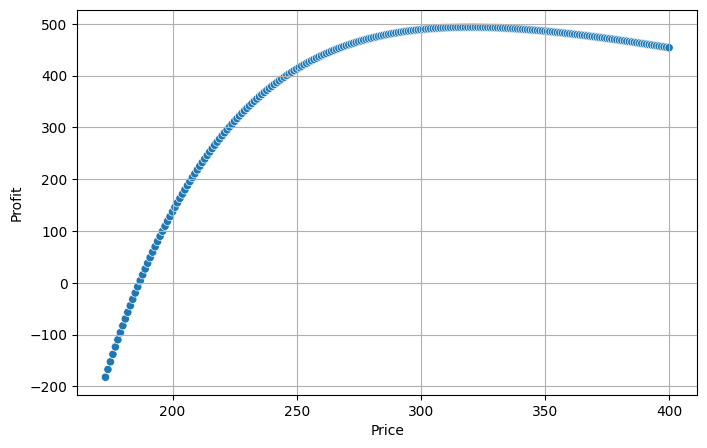

In [32]:
dt_fig1 = pd.DataFrame({
    'price': pricevec * 100,
    'pi1': pivec * 100 / 10000
})

# Rのpivot_longerに相当する melt（ここでは列が1つなので必要ないけど一応）
dt_fig1_long = dt_fig1.melt(id_vars='price', var_name='name', value_name='value')

# グラフ描画
plt.figure(figsize=(8, 5))
sns.scatterplot(data=dt_fig1_long, x='price', y='value', hue='name', legend=False)
plt.xlabel('Price')
plt.ylabel('Profit')
plt.grid(True)
plt.show()

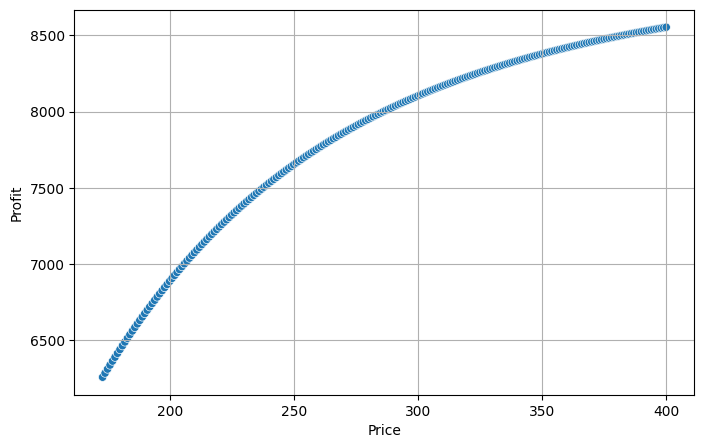

In [33]:
dt_fig2 = pd.DataFrame({
    'price': pricevec * 100,
    'pi2': pivec2 * 100 / 10000
})

# Rのpivot_longerに相当
dt_fig2_long = dt_fig2.melt(id_vars='price', var_name='name', value_name='value')

# グラフの描画
plt.figure(figsize=(8, 5))
sns.scatterplot(data=dt_fig2_long, x='price', y='value', hue='name', legend=False)
plt.xlabel('Price')
plt.ylabel('Profit')
plt.grid(True)
plt.show()

In [34]:
from scipy.optimize import minimize_scalar

def neg_f_revenue(price, option):
    return -f_revenue(data=df, datalist=datalist,  result2=result2, parameter=parameter, option=option, car_id=name_id_target, year=2016, new_price=price, elasmat=selected_elasmat)

res = minimize_scalar(neg_f_revenue, bounds=(0.3, 5), method='bounded', args=('ownpi'))
# 最適な価格と最大収益
optimal_price = res.x
max_profit = -res.fun  # 符号を元に戻す

print(f"最適な価格: {optimal_price}")
print(f"最大利潤: {max_profit}")

最適な価格: 3.197999697309652
最大利潤: 49358.47200952261


In [35]:
res = minimize_scalar(neg_f_revenue, bounds=(0.3, 5), method='bounded', args=('totalpi'))
# 最適な価格と最大収益
optimal_price = res.x
max_profit = -res.fun  # 符号を元に戻す

print(f"最適な価格: {optimal_price}")
print(f"最大利潤: {max_profit}")

最適な価格: 4.9999952176612235
最大利潤: 874778.5778753316
